<a href="https://colab.research.google.com/github/AshTheFallen/Irish-energy/blob/main/CNN_Irish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('/content/gdrive/MyDrive/datasets/daily-electricity-usage/irish_grid.csv', delimiter = ',')
df.head()

,id,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1000,2009-07-15,0.167,0.050,0.166,0.066,0.072,0.153,0.048,0.162,0.138,0.206,0.059,0.120,0.141,0.058,0.198,0.061,0.110,0.127,0.052,5.050,1.390,0.984,1.262,0.363
1,1000,2009-07-16,0.087,0.106,0.130,0.050,0.163,0.050,0.187,0.935,0.079,0.149,0.058,0.174,0.059,0.135,0.100,0.212,0.130,0.069,3.590,0.109,0.185,0.795,0.532,0.319
2,1000,2009-07-17,0.218,0.048,0.183,0.090,0.126,0.185,0.211,0.905,0.516,0.262,0.123,0.185,0.064,0.363,0.291,0.659,0.574,0.421,0.500,0.439,0.207,0.081,0.067,0.507
3,1000,2009-07-18,0.323,0.050,0.133,0.060,0.145,0.049,0.154,0.443,0.532,0.058,0.140,0.058,0.167,0.058,0.162,0.059,0.162,0.058,3.096,3.265,1.415,0.224,0.276,0.251
4,1000,2009-07-19,0.227,0.140,0.057,0.151,0.050,0.133,0.182,0.122,0.086,0.254,1.561,3.031,0.612,0.659,0.710,2.423,0.099,0.110,0.066,0.148,0.098,0.216,0.062,0.109


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


         0      1      2      3      4  ...     19     20     21     22     23
0    0.167  0.050  0.166  0.066  0.072  ...  5.050  1.390  0.984  1.262  0.363
1    0.087  0.106  0.130  0.050  0.163  ...  0.109  0.185  0.795  0.532  0.319
2    0.218  0.048  0.183  0.090  0.126  ...  0.439  0.207  0.081  0.067  0.507
3    0.323  0.050  0.133  0.060  0.145  ...  3.265  1.415  0.224  0.276  0.251
4    0.227  0.140  0.057  0.151  0.050  ...  0.148  0.098  0.216  0.062  0.109
..     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
531  0.150  0.155  0.050  0.097  0.105  ...  2.146  1.500  1.259  1.155  0.573
532  0.139  0.165  0.040  0.159  0.057  ...  0.610  0.628  0.753  0.605  0.532
533  0.226  0.082  0.040  0.040  0.126  ...  1.392  1.093  1.382  1.027  0.583
534  0.180  0.041  0.065  0.135  0.040  ...  1.221  0.874  1.030  0.982  0.945
535  0.466  0.123  0.170  0.040  0.040  ...  3.267  2.728  1.193  1.895  1.445

[536 rows x 24 columns]


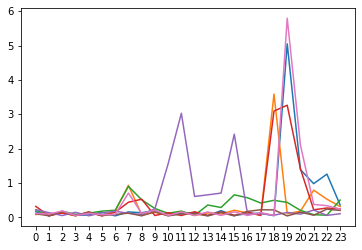

In [ ]:
# plotting 1 week for 1 user

id = 1000
user = df.loc[(df['id'] == id)]
user.drop(columns=['date','id'],inplace= True)
print(user)
for i in range(7):
  plt.plot(user.iloc[i])


In [ ]:
# Add anomalies to users's data

import random

# We split the user's data into segments with pre-defined length
# Then we randomly choose a number of them to change

SPLIT_SIZE = 7
labels = []
ids = []
# Attacks

# random 0.2 - 0.8
def attack1(seg):
  return seg * random.uniform(0.2, 0.8)

# random each element 0.2 - 0.8
def attack2(seg):
  return [i* random.uniform(0.2, 0.8) for i in seg]

# mean
def attack3(seg):
  return np.full((seg.shape),seg.mean())

# fraction of mean
def attack4(seg):
  return np.full((seg.shape),seg.mean() * random.uniform(0.2, 0.8))

# reverse
def attack5(seg):
  return seg[::-1]

# zero
def attack6(seg):
  return np.zeros((seg.shape))

def attack7(seg):
  pass

def attack_generator(split_df,SPLIT_SIZE,id):
  MIN_MALICIOUS_HOURS = 48
  MAX_MALICIOUS_HOURS = SPLIT_SIZE * 24

  random_start = random.randint(0,MAX_MALICIOUS_HOURS-MIN_MALICIOUS_HOURS) # choose a random starting point for anomaly in all the hours with 48 hours minimum
  affected = random.randint(MIN_MALICIOUS_HOURS,MAX_MALICIOUS_HOURS - random_start) # choose number of affected hours
  attack_list = [attack1,attack2,attack3,attack4,attack5,attack6]
  # print('affected = {}, random_start = {}'.format(affected,random_start))
  if random.random() < 0.5:
    labels.append(1)
    split_df[random_start:random_start + affected] = attack_list[random.randint(0,len(attack_list)-1)](split_df[random_start:random_start + affected])
  else:
    labels.append(0)
    
  # print(len(labels))
  ids.append(id)
  return split_df

# We will create 2 datasets. In the first one we have daily vectors and a labels for each 7 days. 
# In the second dataset we have weekly vectors and one label for each row

# labels = []
# split_df_list = [user.iloc[i:i + SPLIT_SIZE].to_numpy().flatten() for i in range(0, len(user) - SPLIT_SIZE + 1, SPLIT_SIZE)] 
# changed_split_df_list = [attack_generator(i,SPLIT_SIZE) for i in split_df_list]


In [ ]:
print(labels)
labels = np.array(labels)
# changed_split_df_list = [i.reshape(-1,24) for i in changed_split_df_list]
# changed_split_df_array = np.concatenate( changed_split_df_list, axis=0 )
# new_user = pd.DataFrame(changed_split_df_array)
new_user = pd.DataFrame(changed_split_df_list)
new_user.to_csv('/content/gdrive/MyDrive/datasets/daily-electricity-usage/user1000_week.csv')
# new_user.to_csv('/content/gdrive/MyDrive/datasets/daily-electricity-usage/user1000_day.csv')

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0]


In [ ]:
# np.bincount(labels)
df

,id,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1000,2009-07-15,0.167,0.050,0.166,0.066,0.072,0.153,0.048,0.162,0.138,0.206,0.059,0.120,0.141,0.058,0.198,0.061,0.110,0.127,0.052,5.050,1.390,0.984,1.262,0.363
1,1000,2009-07-16,0.087,0.106,0.130,0.050,0.163,0.050,0.187,0.935,0.079,0.149,0.058,0.174,0.059,0.135,0.100,0.212,0.130,0.069,3.590,0.109,0.185,0.795,0.532,0.319
2,1000,2009-07-17,0.218,0.048,0.183,0.090,0.126,0.185,0.211,0.905,0.516,0.262,0.123,0.185,0.064,0.363,0.291,0.659,0.574,0.421,0.500,0.439,0.207,0.081,0.067,0.507
3,1000,2009-07-18,0.323,0.050,0.133,0.060,0.145,0.049,0.154,0.443,0.532,0.058,0.140,0.058,0.167,0.058,0.162,0.059,0.162,0.058,3.096,3.265,1.415,0.224,0.276,0.251
4,1000,2009-07-19,0.227,0.140,0.057,0.151,0.050,0.133,0.182,0.122,0.086,0.254,1.561,3.031,0.612,0.659,0.710,2.423,0.099,0.110,0.066,0.148,0.098,0.216,0.062,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301512,7444,2010-10-14,0.701,0.540,0.383,0.382,0.398,0.611,2.100,2.367,1.445,2.367,2.073,1.775,0.810,1.266,0.534,0.787,1.194,1.130,1.870,2.214,1.998,1.962,1.635,1.526
3301513,7444,2010-10-15,1.122,0.426,0.440,0.397,0.400,0.620,1.522,1.591,1.813,0.937,3.240,2.094,1.593,1.063,1.156,1.075,2.530,2.494,2.586,2.896,2.016,2.687,1.430,0.721
3301514,7444,2010-10-16,0.730,0.528,0.425,0.422,0.431,0.884,1.527,1.630,1.852,1.607,1.837,2.065,1.989,1.079,1.296,1.306,1.027,0.393,6.095,2.452,2.290,2.751,1.475,1.094
3301515,7444,2010-10-17,0.994,0.991,1.004,0.956,1.126,1.370,1.142,2.274,4.311,2.203,0.797,0.937,0.791,1.174,0.749,1.136,0.919,1.286,1.990,3.870,2.246,2.222,1.018,0.673


In [ ]:
df.drop(columns=['date'],inplace = True)
pdList = []
def expand_to_all(user):
  
  id = user.iloc[0,0]
  temp = user.iloc[:,1:]
  split_df_list = [temp.iloc[i:i + SPLIT_SIZE].to_numpy().flatten() for i in range(0, len(temp) - SPLIT_SIZE + 1, SPLIT_SIZE)] 
  changed_split_df_list = [attack_generator(i,SPLIT_SIZE,id) for i in split_df_list]
  pdList.append(pd.DataFrame(changed_split_df_list))


df.groupby(['id']).apply(lambda x: expand_to_all(x))

""


In [ ]:
labels = np.array(labels)
ids = np.array(ids)
final_df = pd.concat(pdList, ignore_index=True)
print(final_df.shape,labels.shape)
final_df['label'] = labels
final_df['id'] = ids

(468121, 168) (468121,)


In [ ]:
final_df.head()
final_df.to_csv('/content/gdrive/MyDrive/datasets/daily-electricity-usage/irish_grid_anomaly.csv')

In [ ]:
final_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,label,id
0,0.167,0.050,0.166,0.066,0.072,0.153,0.048,0.162,0.138,0.206,0.059,0.120,0.141,0.058,0.198,0.061,0.110,0.127,0.052,5.050,1.390,0.984,1.262,0.363,0.087,0.106,0.130,0.050,0.163,0.050,0.187,0.935,0.079,0.149,0.058,0.174,0.059,0.135,0.100,0.212,...,0.048,0.103,0.112,0.046,0.147,0.046,0.177,0.225,0.221,0.046,0.154,0.067,0.244,0.205,0.120,0.100,0.189,0.058,0.123,0.083,0.087,0.711,0.120,0.214,0.058,0.163,0.058,0.163,0.060,0.165,0.059,0.142,0.060,5.795,2.103,0.381,0.343,0.245,0,1000
1,0.073,0.150,0.064,0.150,0.056,0.149,0.076,0.258,0.115,0.145,0.616,0.524,0.316,0.229,0.064,0.165,0.068,0.314,0.205,0.158,0.049,0.302,0.192,0.172,0.050,0.147,0.050,0.167,0.050,0.165,0.244,3.868,0.139,0.111,0.092,0.142,0.064,0.165,0.057,0.156,...,3.682,2.536,0.774,0.668,0.826,0.155,2.103,2.344,2.118,0.569,0.446,0.077,0.211,0.204,0.061,0.153,0.242,0.062,0.170,0.081,2.523,0.511,0.170,0.098,0.133,0.093,0.132,0.096,0.108,0.117,0.108,0.120,2.738,2.101,0.412,0.156,0.494,0.197,0,1000
2,0.158,0.049,0.169,0.050,0.171,0.050,0.127,1.547,0.147,0.093,0.095,0.133,0.060,0.173,0.058,0.172,0.060,3.550,1.757,0.945,0.220,0.331,0.196,0.214,0.050,0.618,0.120,0.050,0.169,0.049,0.089,1.510,0.069,0.227,0.114,0.066,0.174,0.061,0.180,0.064,...,0.074,0.065,0.161,0.048,0.152,0.075,0.059,0.143,0.048,0.172,0.056,0.069,0.154,0.049,0.150,0.077,0.050,0.178,0.051,0.122,0.110,0.050,0.176,0.050,0.077,0.149,0.048,0.154,0.048,0.124,0.324,0.393,1.113,0.838,0.805,0.246,0.273,0.134,0,1000
3,0.159,0.857,0.121,0.223,0.062,0.115,0.123,0.061,0.232,0.134,0.181,0.047,0.173,0.070,0.145,0.229,0.106,0.247,0.284,0.338,0.158,1.662,4.999,0.317,0.196,0.062,0.168,0.102,0.089,0.179,0.062,0.203,0.075,0.616,0.244,0.064,0.220,0.386,2.832,0.191,...,0.252,0.239,2.522,1.546,1.159,0.141,0.193,0.122,0.200,0.116,0.200,0.115,0.193,0.224,0.433,3.157,0.230,0.235,0.101,0.233,0.104,0.160,0.348,0.058,0.147,0.109,0.064,0.190,0.057,0.164,0.086,0.086,0.165,0.369,0.375,0.393,0.309,0.231,1,1000
4,0.076,0.113,0.121,0.049,0.185,0.049,0.149,3.162,0.115,0.136,0.060,0.225,0.229,0.060,0.126,0.139,1.991,2.968,0.916,0.164,0.261,0.526,0.644,0.714,0.094,0.174,0.148,0.196,0.050,0.187,0.057,0.134,0.757,0.155,0.102,0.134,0.122,0.094,0.167,0.062,...,0.099,0.132,0.050,0.187,0.050,0.158,0.066,0.259,0.647,0.410,0.286,0.732,0.726,0.113,0.114,0.322,0.132,0.174,0.051,0.183,0.052,7.996,0.930,0.773,0.736,0.147,0.729,0.084,0.791,0.064,0.798,0.060,0.181,0.173,0.334,0.259,0.367,0.070,0,1000


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

# creating train and test datasets

dataset = final_df.iloc[:,:-2].to_numpy()
# print(dataset)
X_train,X_test,y_train,y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = models.Sequential([
                           layers.Conv1D(kernel_size = 5, filters = 32, activation= 'relu', input_shape=(168,1)),
                           layers.MaxPooling1D(pool_size=2),
                           layers.Conv1D(kernel_size = 5, filters = 32, activation= 'relu'),
                           layers.Dropout(0.5),
                           layers.MaxPooling1D(pool_size=3),
                           layers.Conv1D(kernel_size = 5, filters = 32, activation= 'relu'), 
                           layers.Flatten(),
                           layers.Dense(736, activation='sigmoid'),
                           layers.Dense(1)

])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 164, 32)           192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 82, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 78, 32)            5152      
_________________________________________________________________
dropout (Dropout)            (None, 78, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 26, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 32)            5152      
_________________________________________________________________
flatten (Flatten)            (None, 704)               0

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer='Adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(epochs = 5, verbose = True, x = X_train,y = y_train, validation_data=(X_test,y_test))

Epoch 1/5
11703/11703 [==============================] - 95s 6ms/step - loss: nan - accuracy: 0.6591 - val_loss: nan - val_accuracy: 0.5001
Epoch 2/5
11703/11703 [==============================] - 66s 6ms/step - loss: nan - accuracy: 0.5020 - val_loss: nan - val_accuracy: 0.5001
Epoch 3/5
11703/11703 [==============================] - 66s 6ms/step - loss: nan - accuracy: 0.5020 - val_loss: nan - val_accuracy: 0.5001
Epoch 4/5
11703/11703 [==============================] - 65s 6ms/step - loss: nan - accuracy: 0.5020 - val_loss: nan - val_accuracy: 0.5001
Epoch 5/5
11703/11703 [==============================] - 62s 5ms/step - loss: nan - accuracy: 0.5020 - val_loss: nan - val_accuracy: 0.5001
